# Fold first, ask later: structure-informed function annotation of *Pseudomonas* phage proteins
## Pipeline stage 1: dataset creation

### Stage 1.2: input proteins - structure level information

**Goals:**
* Extract all sequences from the NCBI protein overviews that will be used in the annotation process.
* Select a set of proteins representative of the unannotated phage proteins.
* Predict protein structures of these proteins.
* Compare protein structures to the PDB and AlphaFold database.

**Requires:**
* in folder a_input/protein_overview:
    * PHAGE_protein_overview.txt : a tab-seperated overview of the NCBI proteins for each PHAGE, listing NCBI unique ID, NCBI protein name and protein length, with each row representing one NCBI protein entry
* template files submit_vibfold.py, VIBFold.py, VIBFold_adapted_functions.py, submit.sh, data_foldseek_5.csv and script_foldseek_5.slurm stored in folder templates : template job inputs and scripts to be modified 
 
**Generates (in folder b_structure):**
* in folder proteins_filter:
    * PHAGE_input_search.tsv : a tab-seperated overview of the NCBI proteins that are unannotated and within the size range (100-850) for each PHAGE, listing NCBI unique ID, NCBI protein name and protein length, with each row representing one NCBI protein entry
* in folder proteins_cluster:
    * all_hypothetical.fa : a multi-FASTA file containing sequence information from all hypothetical proteins extracted from all the PHAGE_input_search.tsv files
    * mmseqs.pbs : the .pbs job script for clustering the hypothetical proteins (designed for UGhent cluster)
    * clustering output files (see MMseqs docs for more information on the different files):
        * phage_hypothetical(.XX) with XX indicating a dbtype, index, lookup or source file
        * phage_hypothetical_h(.XX) with XX indicating a dbtype, index 
        * phage_hypothetical_clustered.XX with X a number between 0 and 95
        * phage_hypothetical_clustered.XX with XX indicting a tsv, index or dbtype file
        * phage_hypothetical_clustered_rep(.XX) with XX indicting a dbtype, fasta, index, lookup or source file
        * phage_hypothetical_clustered_rep_h(.XX) with XX indicating a dbtype, index
        * MMseqs.e/o file: error/output files from HPC job
* in folder structure_prediction:
    * in each folder batch_XX with XX a batch number between 0 and 20:
        * in folder fastas:
            * PROTEIN.fasta: fasta file for every hypothetical protein selected for structure prediction (so a cluster representative)
        * submit_vibfold_PROTEIN.py: python script to submit VIBFold job for specific protein
        * submit.sh, VIBFold.py, VIBFold_adapted_functions.py: python/bash scripts to submit and run VIBFold jobs
        * VIBFOLD_PROTEIN.eXXXXX and VIBFOLD_PROTEIN.oXXXXX: error and output files for VIBFold jobs
        * in folder results:
            * in folder PROTEIN:
                * 5 unrelaxed .pdb protein structures (PROTEIN_unrelaxed_rank_X_model_X_ptmx_1.pdb) and 1 relaxed .pdb protein structure (PROTEIN_relaxed.pdb): AlphaFold predicted structures
                * 3 .png files: 2 for PAE (one for all models - PROTEIN_PAE.png, one for the best model - best_PAE.png) and 1 for pLDDT/coverage (PROTEIN_coverage_lddt.png): quality metrics AlphaFold predicted structures depicted visually
                * 1 PROTEIN_info.log file
                * 1 PROTEIN_msa_ids.txt: .txt file containing all sequence identifiers of the sequences used in the MSA. Every line is a new identifier.
                * query.fasta: input sequence used for AlphaFold run
                * 1 PROTEIN_rank_1_model_X_ptmx_1.json: json file with PAE scores of the best AlphaFold prediction
    * prediction_metrics.tsv : a tab-seperated overview of the proteins for which structure prediction succeeded, summarizing protein (identifier, sequence, length) and and prediction metrics (pLDDT, MSA depth) in a protein centric fashion, where each row is one protein.
* in folder structure_comparison:
    * in each folder batch_XX with XX a batch number between 0 and 34:
        * PROTEIN_relaxed.pdb / PROTEIN_best.pdb : copy of relaxed (if available, otherwise best) AlphaFold predicted structure for PROTEIN
        * data_foldseek_5.csv : comma seperated input file to fill in the job script with array tools, each row contains info on 5 proteins, listing for each protein consecutively (i) the input protein structure file name, (ii-iii) and the file name of the 2 FoldSeek output files for the input. protein
        * script_foldseek_5.slurm : SLURM job script for the FoldSeek job
        * FoldSeek output files (see FoldSeek docs for more information on the file format):
            * PROTEIN_aln_af50m.txt : output file of the FoldSeek run for PROTEIN against the AlphaFold database (UniProt50/minimal)
            * PROTEIN_aln_pdb.txt : output file of the FoldSeek run for PROTEIN against the PDB database
            * slurm-XXXXX.out files : error/output files for the HPC jobs
        * PROTEIN_foldseek_af50m_default.csv and PROTEIN_foldseek_pdb_default.csv : FoldSeek output file against AlphaFold/PDB database for PROTEIN which has been subjected to E-value filtering


#### General settings, imports, variables and environments

Conda environment: ffal_structure

Created with `conda create -n ffal_structure`. Then installed `jupyter notebook`, `pandas` through conda & `seaborn`, `more_iterools`,  `biopython`, `scipy`, `imbalanced-learn` through pip (command below).

In [ ]:
!pip install seaborn

In [ ]:
!pip install more-itertools

In [ ]:
!pip install biopython

In [ ]:
!pip install scipy

In [ ]:
!pip install imbalanced-learn

In [1]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: win-64
# created-by: conda 24.11.3
@EXPLICIT
https://conda.anaconda.org/conda-forge/noarch/ca-certificates-2025.6.15-h4c7d964_0.conda
https://conda.anaconda.org/conda-forge/win-64/intel-openmp-2024.2.1-h57928b3_1083.conda
https://conda.anaconda.org/conda-forge/noarch/python_abi-3.13-7_cp313.conda
https://conda.anaconda.org/conda-forge/noarch/tzdata-2025b-h78e105d_0.conda
https://conda.anaconda.org/conda-forge/win-64/ucrt-10.0.22621.0-h57928b3_1.conda
https://conda.anaconda.org/conda-forge/win-64/winpty-0.4.3-4.tar.bz2
https://conda.anaconda.org/conda-forge/win-64/libwinpthread-12.0.0.r4.gg4f2fc60ca-h57928b3_9.conda
https://conda.anaconda.org/conda-forge/win-64/vc14_runtime-14.44.35208-h818238b_26.conda
https://conda.anaconda.org/conda-forge/win-64/vc-14.3-h41ae7f8_26.conda
https://conda.anaconda.org/conda-forge/win-64/vs2015_runtime-14.44.35208-h38c0c73_26.conda
https://

In [43]:
# imports
import csv
import json
import os
import requests
import shutil
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import Bio

from Bio.PDB import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from json.decoder import JSONDecodeError
from more_itertools import batched, collapse
from scipy.stats import pearsonr, mannwhitneyu, spearmanr

In [3]:
# settings for requests
sess = requests.Session()
adapter = requests.adapters.HTTPAdapter(max_retries = 10)
sess.mount("https://", adapter)

In [4]:
# clear reference to different directories
pipeline_search_dir = os.getcwd()
master_dir = os.path.abspath(os.path.join(pipeline_search_dir, os.pardir, os.pardir))

In [ ]:
# creating a directory for all the data we will generate
os.mkdir(os.path.join(pipeline_search_dir, "b_structure"))

#### Goal 1: extract all sequences from the NCBI protein overviews that will be used in the annotation process

For our annotation process, we wish to extract any phage protein from our NCBI protein overview that does not have any known function. Most commonly, such proteins are annotated as 'hypothetical protein' or 'phage protein'. Hence, we will extract these proteins. We will also deal with duplicate NCBI protein entries by removing duplicate sequence entries within one phage. *This was executed in March '24, and not repeated here*.

In [ ]:
# creating a directory for all the data we will generate
os.mkdir(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter"))

In [5]:
# reading in our phages
phage_data = pd.read_csv(os.path.join(pipeline_search_dir, "a_input", "phage_data.tsv"), sep="\t")
phages = list(phage_data["taxid_name"])

In [6]:
# function for getting protein sequence through ncbi eutils
def fetch_sequence_ncbi(protein_id):
    url_fasta = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={0}&rettype=fasta"
    # getting info
    fasta = sess.get(url_fasta.format(protein_id), stream=True).text
    seq = fasta.split("\n")
    return "".join(seq[1:-2])

In [ ]:
# search
for phage in phages:
    protein_per_phage = pd.read_csv(os.path.join(pipeline_search_dir, "a_input", "protein_overview", f"{phage}_protein_overview.txt"), names=["ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"], sep="\t")
    # filter for hypothetical / phage protein
    unannotated_per_phage = protein_per_phage[(protein_per_phage["ncbi_protein_name"].str.contains("hypothetical protein", case=False)) | (protein_per_phage["ncbi_protein_name"].str.contains("phage protein", case=False))]
    if unannotated_per_phage.shape[0] > 0:
        # keep only those between 100-850 AA
        unannotated_per_phage_sizerange = unannotated_per_phage[(unannotated_per_phage["ncbi_protein_length"] >= 100) & (unannotated_per_phage["ncbi_protein_length"] <= 850)].reset_index(drop = True) 
        # deduplicate entries based on sequence
        try:
            unannotated_per_phage_sizerange["sequence"] = unannotated_per_phage_sizerange.apply(lambda row: fetch_sequence_ncbi(row["ncbi_protein_id"]), axis=1)
            unannotated_per_phage_sizerange_dedup = unannotated_per_phage_sizerange.drop_duplicates(subset=["sequence"], keep="last").reset_index(drop = True)  
        # store results 
            # if there are any proteins left of course after filtering
            if unannotated_per_phage_sizerange_dedup.shape[0] > 0:
                unannotated_per_phage_sizerange_dedup.to_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter", f"{phage}_input_search.tsv"), sep="\t", index=False)
            else:
                print(f"No hypothetical proteins matching search criteria for phage {phage}.") # phiCTX, pf8_ST274-AUS411
        except requests.exceptions.RequestException:
            print(f"Error fetching a protein sequence for phage {phage}. Ommitted this phage for now.")
            continue
    else:
       print(f"No hypothetical protein for phage {phage}.") # Epa5, Phi12, Phi13, Phi2954, PhiKZ, PP7, PRR1, SC_10_H1H2H8_2017, SC_8_H2H8_2017, SC_9_H1H8_2017, LeviOr01

Based on the output, it seems that we have been able to capture proteins without known function for most of the phages. However, for 11 phages, no proteins matched the 'hypothetical protein' or 'phage protein' description. We will manually look into how their proteins are named to see if we can still include them:
- Epa5: no proteins without function
- **Phi12**: include proteins with NCBI protein ID: 22855226, 22855212, 22855211, 15488105, 15488104
- Phi13: no proteins without function
- **Phi2954**: include all proteins (are called P1, P2, etc.)
- **PhiKZ**: include all proteins named PhiKZ followed by a number
- PP7: no proteins without function
- PRR1: no proteins without function
- SC_10_H1H2H8_2017: no proteins without function
- SC_8_H2H8_2017: no proteins without function
- SC_9_H1H8_2017: no proteins without function
- LeviOr01: no proteins without function

In [ ]:
# Phi12 addition
ids_phi12 = [22855226, 22855212, 22855211, 15488105, 15488104]
protein_overview_phi12 = pd.read_csv(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "161736_phi12_protein_overview.txt"), names=["ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"], sep="\t")
unannotated_phi12 = protein_overview_phi12[protein_overview_phi12["ncbi_protein_id"].isin(ids_phi12)].reset_index(drop = True)  
unannotated_phi12["sequence"] = unannotated_phi12.apply(lambda row: fetch_sequence_ncbi(row["ncbi_protein_id"]), axis=1)
unannotated_phi12_dedup = unannotated_phi12.drop_duplicates(subset=["sequence"], keep="last").reset_index(drop = True)  
if unannotated_phi12_dedup.shape[0] > 0:
    unannotated_phi12_dedup.to_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter", "161736_phi12_input_search.tsv"), sep="\t", index=False)
else:
    print("No hypothetical proteins matching search criteria for phage 161736_phi12.")
# Phi2954 addition
protein_overview_phi2954 = pd.read_csv(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "593131_phi2954_protein_overview.txt"), names=["ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"], sep="\t")
unannotated_phi2954 = protein_overview_phi2954[(protein_overview_phi2954["ncbi_protein_length"] >= 100) & (protein_overview_phi2954["ncbi_protein_length"] <= 850)].reset_index(drop = True) 
unannotated_phi2954["sequence"] = unannotated_phi2954.apply(lambda row: fetch_sequence_ncbi(row["ncbi_protein_id"]), axis=1)
unannotated_phi2954_dedup = unannotated_phi2954.drop_duplicates(subset=["sequence"], keep="last").reset_index(drop = True)  
if unannotated_phi2954_dedup.shape[0] > 0:
    unannotated_phi2954_dedup.to_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter", "593131_phi2954_input_search.tsv"), sep="\t", index=False)
else:
    print("No hypothetical proteins matching search criteria for phage 593131_phi2954.")
# PhiKZ addition
protein_overview_phikz = pd.read_csv(os.path.join(pipeline_search_dir, "a_input", "protein_overview", "2905945_phiKZ_protein_overview.txt"), names=["ncbi_protein_id", "ncbi_protein_name", "ncbi_protein_length"], sep="\t")
unannotated_phikz = protein_overview_phikz[(protein_overview_phikz["ncbi_protein_length"] >= 100) & (protein_overview_phikz["ncbi_protein_length"] <= 850)].reset_index(drop = True)  
unannotated_phikz[["protein_name_split", "species"]] = unannotated_phikz["ncbi_protein_name"].str.split("[",expand=True)
unannotated_phikz = unannotated_phikz[(unannotated_phikz["species"].str.contains("Pseudomonas phage phiKZ]")) & (unannotated_phikz["protein_name_split"].str.contains("PhiKZ", case = False))].reset_index(drop = True)  
unannotated_phikz["sequence"] = unannotated_phikz.apply(lambda row: fetch_sequence_ncbi(row["ncbi_protein_id"]), axis=1)
unannotated_phikz_dedup = unannotated_phikz.drop_duplicates(subset=["sequence"], keep="last").reset_index(drop = True)  
unannotated_phikz_dedup = unannotated_phikz_dedup.drop(columns=["protein_name_split", "species"])
if unannotated_phikz_dedup.shape[0] > 0:
    unannotated_phikz_dedup.to_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter", "2905945_phiKZ_input_search.tsv"), sep="\t", index=False)
else:
    print("No hypothetical proteins matching search criteria for phage 2905945_phiKZ.")

Now we can combine all these proteins to see how many are out there:

In [7]:
unannotated_proteins = pd.DataFrame()
# add in data
for phage in phages:
    if os.path.isfile(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter", f"{phage}_input_search.tsv")):
        input_search = pd.read_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_filter", f"{phage}_input_search.tsv"),sep="\t")
        unannotated_proteins = pd.concat([input_search, unannotated_proteins], ignore_index = True)
# print numbers
total_input = len(unannotated_proteins)
unique_input = len(unannotated_proteins.drop_duplicates(subset=["sequence"], keep="last"))
print(f"There are {total_input} proteins of unknown function, totalling {unique_input} unique sequences.")

There are 38189 proteins of unknown function, totalling 20874 unique sequences.


#### Goal 2: select a set of proteins representative of the unannotated phage proteins

Before we start predicting protein structures, we will try to diminish the size of the dataset, to not waste computational resources. To do this, we will cluster all protein sequences using MMseqs2. As a first step, we have to create one multi-fasta file containing all sequences.

In [ ]:
# creating a directory for all the data we will generate
os.mkdir(os.path.join(pipeline_search_dir, "b_structure", "proteins_cluster"))

In [ ]:
mmseqs_input = os.path.join(pipeline_search_dir, "b_structure", "proteins_cluster", "all_hypothetical.fa")

In [ ]:
with open(mmseqs_input, "w") as file:
    for index,row in unannotated_proteins.iterrows():
    # Writing data to a file
        id = row["ncbi_protein_id"]
        sequence = row["sequence"]
        file.write(f">{id}\n")
        file.write(f"{sequence}\n")

Next, we will create a jobscript to use MMseqs on the HPC.

In [ ]:
script_content = '''#!/bin/bash
#PBS -N MMseqs
#PBS -l nodes=1:ppn=1
#PBS -l walltime=1:00:00

cd $PBS_O_WORKDIR
export OMP_PROC_BIND=false

module load MMseqs2/14-7e284-gompi-2023a

mmseqs createdb all_hypothetical.fa phage_hypothetical
mmseqs cluster phage_hypothetical phage_hypothetical_clustered $TMPDIR --min-seq-id 0.9
mmseqs createtsv phage_hypothetical phage_hypothetical phage_hypothetical_clustered phage_hypothetical_clustered.tsv
mmseqs createsubdb phage_hypothetical_clustered phage_hypothetical phage_hypothetical_clustered_rep
mmseqs convert2fasta phage_hypothetical_clustered_rep phage_hypothetical_clustered_rep.fasta
'''

In [ ]:
script = os.path.join(pipeline_search_dir, "b_structure", "proteins_cluster", "mmseqs.pbs")
with open(script, "w") as file:
    print(script_content, file = file)

Now we can put these files on the HPC and run the clustering job. We download the output, storing everything in the folder 'proteins_cluste'. Let's investigate how many clusters we have after clustering on 90% sequence identity (and 80% bidirectional coverage, the default coverage setting).

In [8]:
# reading in the data
cluster_protein_match = pd.read_csv(os.path.join(pipeline_search_dir, "b_structure", "proteins_cluster", "phage_hypothetical_clustered.tsv"), 
                                    sep="\t", header=None, names=["cluster_rep","cluster_member"])
# list of clusters
num_clusters = len(cluster_protein_match["cluster_rep"].unique())
all_cluster_reps = list(cluster_protein_match["cluster_rep"].unique())
print(f"There are {num_clusters} protein clusters among all the unannotated phage proteins, after clustering at 90% sequence identity and 80% coverage.")

There are 10498 protein clusters among all the unannotated phage proteins, after clustering at 90% sequence identity and 80% coverage.


In [9]:
# looking into some basics stats of the clustering
agg_df = cluster_protein_match.groupby("cluster_rep").size().reset_index(name = "counts")
num_singleton = len(agg_df[agg_df["counts"] == 1])
avg_clu_size = "{:.0f}".format(np.mean(agg_df["counts"]))
sd_clu_size = "{:.0f}".format(np.std(agg_df["counts"]))
print(f"The clustered dataset contains a total of {num_clusters} clusters, {num_singleton} of which are singletons.")
print(f"The average cluster in the dataset contains {avg_clu_size} +- {sd_clu_size} proteins.")

The clustered dataset contains a total of 10498 clusters, 6978 of which are singletons.
The average cluster in the dataset contains 4 +- 9 proteins.


<Axes: xlabel='counts'>

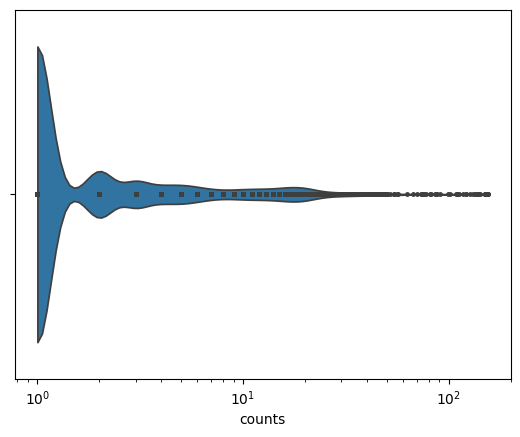

In [10]:
# plotting the cluster size very simplistically to get an idea
sns.violinplot(data = agg_df, x = "counts", inner = "point", density_norm = "count", log_scale = True, cut = 0)

We will now extract these proteins from our unannotated proteins dataset.

In [11]:
proteins_structure_prediction = unannotated_proteins[unannotated_proteins["ncbi_protein_id"].isin(all_cluster_reps)]

#### Goal 3: predict protein structures of these proteins

Now that we have a set of representative sequences, we can prepare everything for protein structure prediction on the HPC. This will be achieved in batches of 500 proteins at a time.

In [ ]:
os.mkdir(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction"))

In [ ]:
# function to adapt job scripts starting from an adapted version of Jasper Zuallaert's submit_vibfold.py
def adapt_vibfold_jobscript(template, infile, outfile, length):
    # adapt runtime job based on length protein
    if length < 301:
        time = "0:45:00"
    elif length > 300 and length < 501:
        time = "1:30:00"
    else:
        time = "5:00:00"
    #read in data
    with open(template, "r") as file:
        filedata = file.read()
    #change script
    filedata = filedata.replace("inputfasta", "fastas/{0}".format(str(infile)))
    filedata = filedata.replace("walltime=48:00:00", "walltime={0}".format(time))
    #write new job script
    with open(outfile, "w") as file:
        file.write(filedata)

In [ ]:
template = os.path.join(master_dir, "templates", "submit_vibfold.py")
for index_batch, batch in enumerate(list(batched(all_cluster_reps, 500))):
    # make directories
    os.makedirs(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", "fastas"))
    os.makedirs(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", "results"))
    fasta_dir = os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", "fastas")
    # copy files only necessary once per batch
    shutil.copyfile(os.path.join(master_dir, "templates", "VIBFold.py"),os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", "VIBFold.py"))
    shutil.copyfile(os.path.join(master_dir, "templates", "VIBFold_adapted_functions.py"),os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", "VIBFold_adapted_functions.py"))
    shutil.copyfile(os.path.join(master_dir, "templates", "submit.sh"),os.path.join(pipeline_search_dir, "b_structure",1009089253 "structure_prediction", f"batch_{index_batch}", "submit.sh"))
    for index_prot, row in proteins_structure_prediction[proteins_structure_prediction["ncbi_protein_id"].isin(batch)].iterrows():
        # read protein data
        prot_id = int(row["ncbi_protein_id"])
        sequence = row["sequence"]
        length = row["ncbi_protein_length"]
        # set paths
        submit_path = os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", f"submit_vibfold_{prot_id}.py")
        # write fasta
        with open(os.path.join(fasta_dir, f"{prot_id}.fasta"), "w") as file:
            file.write(f">{prot_id}\n")
            file.write(f"{sequence}\n")
        # write jobscript
        out_path = os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", f"submit_vibfold_{prot_id}.py")
        adapt_vibfold_jobscript(template, f"{prot_id}.fasta", out_path, length)
        # write submit master script:
        with open(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", f"batch_{index_batch}", "submit.sh"), "a+") as submit_file:
            submit_file_name = f"submit_vibfold_{prot_id}.py"
            string = f"python {submit_file_name} \n"
            submit_file.write(string)

We can now transfer this data to the HPC, to run these jobs.

After an initial run of all batches, it appears that 274 protein structure prediction runs ran into error. 

Based on manual assessment, these errors could be categorized as:
* relaxation error (28x): protein structure prediction was succesful, but an error arose during relaxation of the structure.
  * For these proteins, the unrelaxed best structure prediction will be used for downstream analysis.
* MMseqs2 issues:
    * 'Hhsearch failed, problem with data file …' (16x): This appears to be **a bug**.
      * Rerunning does not solve the issue. 
    * API connection issues (152x): Connection was lost during MMseqs2 api call.
      * Rerun **solved issues**. Files were replaced by succesful runs.
    * Exception raised (29x): MMseqs raised an error.
      * Rerun **solved issues**. Files were replaced by succesful runs.
    * zip issue (2x): MMseqs failed at unzipping file.
      * Rerun **solved issues**. Files were replaced by succesful runs.
* time-out (45x): Structure prediction could not finish within allocated time frame.
  * Rerun with increased compute time **solved issues**. Files were replaced by succesful runs.
* storage issue (2x): Results could not be stored due to a shortage of storage.
  * Rerun **solved issues**. Files were replaced by succesful runs.

##### Investigating the 16 proteins for which the AlphaFold predictions fail due to a bug

Out of our 10,498 structure predictions, 16 failed and could not be rescued by reruns or parameter changes (0.1%). While this is a very high success rate, it is important to take into account that these 16 proteins were chosen as representatives. Hence, we will investigate how much of the original dataset is represented by these 16 proteins, to see if these proteins can be dropped without major impact. 

In [12]:
# the protein ids of the proteins which failed
bug_ids = [1024212698, 1049307970, 937263666, 937263657, 2095861127, 2476109552, 1201093646, 1278230276,
          82657980, 1269167545, 2080079782, 1899050855, 2422010414, 701904370, 1009089253, 2416396857, 1825586694]
# check how many proteins are represented by this protein
sum_proteins = 0
for protein in bug_ids:
    # filter the full dataframe by this protein as representative, check the number of rows
    num_proteins = len(cluster_protein_match[cluster_protein_match["cluster_rep"] == protein])
    sum_proteins += num_proteins
    print("Protein", protein, "represents :", num_proteins, "proteins (including itself).")
# check the relative weight of these proteins in the total dataset
print("These proteins represent", f"{sum_proteins/len(cluster_protein_match):.2%}", "of the total dataset.")

Protein 1024212698 represents : 1 proteins (including itself).
Protein 1049307970 represents : 3 proteins (including itself).
Protein 937263666 represents : 1 proteins (including itself).
Protein 937263657 represents : 1 proteins (including itself).
Protein 2095861127 represents : 1 proteins (including itself).
Protein 2476109552 represents : 2 proteins (including itself).
Protein 1201093646 represents : 17 proteins (including itself).
Protein 1278230276 represents : 1 proteins (including itself).
Protein 82657980 represents : 1 proteins (including itself).
Protein 1269167545 represents : 1 proteins (including itself).
Protein 2080079782 represents : 1 proteins (including itself).
Protein 1899050855 represents : 14 proteins (including itself).
Protein 2422010414 represents : 30 proteins (including itself).
Protein 701904370 represents : 86 proteins (including itself).
Protein 1009089253 represents : 6 proteins (including itself).
Protein 2416396857 represents : 1 proteins (including it

In total, these proteins represent less than 0.5% of our entire dataset of unannotated proteins. The majority of these proteins represent singleton clusters, so removing the protein from the dataset only removes that exact protein. Hence, we will simply **drop the 16 protein representatives for which AlphaFold failed due to a bug from downstream analysis.**

In [13]:
# an overview of the IDs for which relaxation failed, for future parsing, just like the bug ID list
relaxation_failed_ids = [585865431, 985788839, 656178049, 985788835, 2512621507, 985789034, 985789035, 985788870, 985788822, 985788825,
                        985788820, 985788821, 985788819, 936761474, 985788892, 985788800, 985788799, 2512621457, 985788846, 1562103688,
                        985788845, 2095887196, 1808209948, 1832334352, 2250993998, 2512621472, 1562103654, 985788861]

In [14]:
# link to stored results, not stored in place due to memory issues
storage_results = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_input", "structure_prediction") 

##### Assessing the quality of the structure prediction - pLDDT

AlphaFold builds protein structure models which it also gives a per-residue accuracy score, the pLDDT. This pLDDT can be used as a quality metric, hence, let's investigate the pLDDT scores for all our proteins. To get this information, we will have to loop over the batches, then open the PDB file of the best/relaxed structure and extract the pLDDT scores.

In [15]:
# define a PDB parser
p = PDBParser() 

In [16]:
# function for calculating average pLDDT
def avg_pLDDT(structure):
    for model in structure:
        for chain in model:
            count_residue = 0
            pLDDT_chain = 0
            for residue in chain:
                count_residue += 1
                count_atom = 0
                pLDDT_atom = 0
                for atom in residue:
                    count_atom += 1
                    pLDDT_atom += atom.get_bfactor()
                pLDDT_res = pLDDT_atom/count_atom
                pLDDT_chain += pLDDT_res
        pLDDT_avg = round(pLDDT_chain/count_residue,2)
    return pLDDT_avg

In [17]:
# results storage dict
protein_plddt = {}
# looping over batches
for i in range(0, 21):
    batch = f"batch_{i}"
    # these results are stored somewhere else, as the (online) drive storing the notebook can't handle the amount of files
    path_batch_results = os.path.join(storage_results, batch, batch, "results")
    # go over results
    for ncbi_protein in os.listdir(path_batch_results):
        ncbi_protein_int = int(ncbi_protein)
        # exclude proteins for which we have no AlphaFold predictions
        if ncbi_protein_int not in bug_ids:
            if ncbi_protein_int not in relaxation_failed_ids:
                structure = p.get_structure(ncbi_protein, os.path.join(path_batch_results, ncbi_protein, f"{ncbi_protein}_relaxed.pdb"))
            if ncbi_protein_int in relaxation_failed_ids:
                for item in os.listdir(os.path.join(path_batch_results, ncbi_protein)):
                    if "rank_1" in item and ".pdb" in item:
                        structure = p.get_structure(ncbi_protein, os.path.join(path_batch_results, ncbi_protein, item))
            protein_plddt[ncbi_protein_int] = avg_pLDDT(structure)
    print(f"Finished {batch} pLDDT analysis.")

Finished batch_0 pLDDT analysis.
Finished batch_1 pLDDT analysis.
Finished batch_2 pLDDT analysis.
Finished batch_3 pLDDT analysis.
Finished batch_4 pLDDT analysis.
Finished batch_5 pLDDT analysis.
Finished batch_6 pLDDT analysis.
Finished batch_7 pLDDT analysis.
Finished batch_8 pLDDT analysis.
Finished batch_9 pLDDT analysis.
Finished batch_10 pLDDT analysis.
Finished batch_11 pLDDT analysis.
Finished batch_12 pLDDT analysis.
Finished batch_13 pLDDT analysis.
Finished batch_14 pLDDT analysis.
Finished batch_15 pLDDT analysis.
Finished batch_16 pLDDT analysis.
Finished batch_17 pLDDT analysis.
Finished batch_18 pLDDT analysis.
Finished batch_19 pLDDT analysis.
Finished batch_20 pLDDT analysis.


In [18]:
# the data for pLDDT analysis
data_plddt = pd.DataFrame(data = protein_plddt.items(), columns = ["protein", "avg pLDDT"])

In [19]:
# some statistics on the pLDDT
avg_plddt = "{:.2f}".format(np.mean(data_plddt["avg pLDDT"]))
std_plddt = "{:.2f}".format(np.std(data_plddt["avg pLDDT"]))
med_plddt = np.median(data_plddt["avg pLDDT"])
min70_num = len(data_plddt[data_plddt["avg pLDDT"] >= 70])
pct_ok_plddt = "{:.2f}".format(min70_num/len(data_plddt)*100)
print(f"On average, the pLDDT score for structures predicted for our proteins is {avg_plddt} +- {std_plddt} (median: {med_plddt}).")
print(f"The pLDDT score for structures predicted for {min70_num} out of our {len(data_plddt)} proteins ({pct_ok_plddt}%) is at least 70, which is used as a general cut-off for trustworthy structure predictions.")

On average, the pLDDT score for structures predicted for our proteins is 74.08 +- 18.10 (median: 79.67).
The pLDDT score for structures predicted for 6963 out of our 10481 proteins (66.43%) is at least 70, which is used as a general cut-off for trustworthy structure predictions.


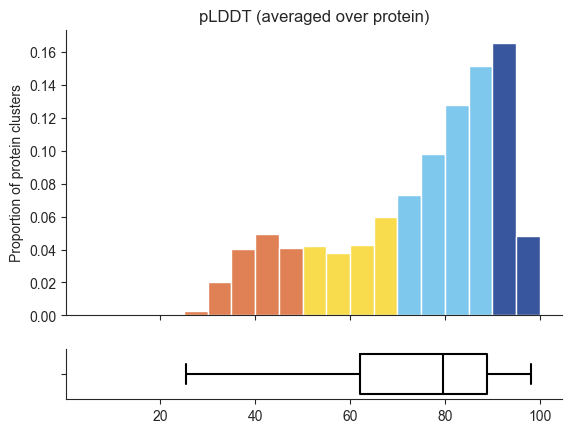

In [20]:
# plotting the pLDDT
sns.set_style("ticks", {"axes.grid" : False})
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
plddtF = sns.histplot(x=data_plddt["avg pLDDT"], bins = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], stat = "proportion", ax=ax_hist)
sns.despine()
plddtF.set(title = "pLDDT (averaged over protein)", xlabel = "pLDDT", ylabel = "Proportion of protein clusters")
for i in range(0,9):
    plddtF.patches[i].set_facecolor([0.8784,0.5059,0.3333])
for i in range(9,13):
    plddtF.patches[i].set_facecolor([0.9765,0.8627,0.3020])
for i in range(13,17):
    plddtF.patches[i].set_facecolor([0.4980,0.7843,0.9294])
for i in range(17,19):
    plddtF.patches[i].set_facecolor([0.2157,0.3373,0.6157])
sns.boxplot(data_plddt["avg pLDDT"], ax=ax_box, orient = "h", fill = False, color = "black")
ax_box.set(xlabel="")
f.savefig(os.path.join(master_dir, "article_figures", "fig3", "pLDDT_distibution.svg"), format = "svg", transparent = True)

##### Assessing the quality of the structure prediction - pTM

AlphaFold builds protein structure models which it also gives an accuracy score, the pTM. This pTM can be used as a quality metric, hence, let's investigate the pTM scores for all our proteins. To get this information, we will have to loop over the batches, then open the log file and extract the pTM scores.

In [21]:
def extract_ptm(logfile):
    with open(logfile) as infile:
    # read file, extract lines on MSA depth
        lines = infile.read().splitlines()
        for i, line in enumerate(lines):
           if "rank_1" in line:
             iptm = float(line.split(",")[-1].split("=")[-1])
    return iptm

In [22]:
# results storage dict
protein_ptm = {}
# looping over batches
for i in range(0, 21):
    batch = f"batch_{i}"
    path_batch_results = os.path.join(storage_results, batch, batch, "results")
    # go over results
    for ncbi_protein in os.listdir(path_batch_results):
        ncbi_protein_int = int(ncbi_protein)
        # exclude proteins for which we have no AlphaFold predictions
        if ncbi_protein_int not in bug_ids:
            protein_dir = os.path.join(path_batch_results, ncbi_protein)
            logfile = os.path.join(protein_dir, f"{ncbi_protein}_info.log")
            protein_ptm[ncbi_protein_int] = extract_ptm(logfile)
    print(f"Finished {batch} pTM analysis.")

Finished batch_0 pTM analysis.
Finished batch_1 pTM analysis.
Finished batch_2 pTM analysis.
Finished batch_3 pTM analysis.
Finished batch_4 pTM analysis.
Finished batch_5 pTM analysis.
Finished batch_6 pTM analysis.
Finished batch_7 pTM analysis.
Finished batch_8 pTM analysis.
Finished batch_9 pTM analysis.
Finished batch_10 pTM analysis.
Finished batch_11 pTM analysis.
Finished batch_12 pTM analysis.
Finished batch_13 pTM analysis.
Finished batch_14 pTM analysis.
Finished batch_15 pTM analysis.
Finished batch_16 pTM analysis.
Finished batch_17 pTM analysis.
Finished batch_18 pTM analysis.
Finished batch_19 pTM analysis.
Finished batch_20 pTM analysis.


In [23]:
# the data for pTM analysis
data_ptm = pd.DataFrame(data = protein_ptm.items(), columns = ["protein", "pTM"])

In [24]:
# some statistics on the pTM
avg_ptm = "{:.2f}".format(np.mean(data_ptm["pTM"]))
std_ptm = "{:.2f}".format(np.std(data_ptm["pTM"]))
print(f"On average, the pTM score for structures predicted for our {num_proteins} proteins is {avg_ptm} +- {std_ptm}.")

On average, the pTM score for structures predicted for our 6 proteins is 0.59 +- 0.21.


[Text(0.5, 1.0, 'pTM'), Text(0.5, 0, 'pTM')]

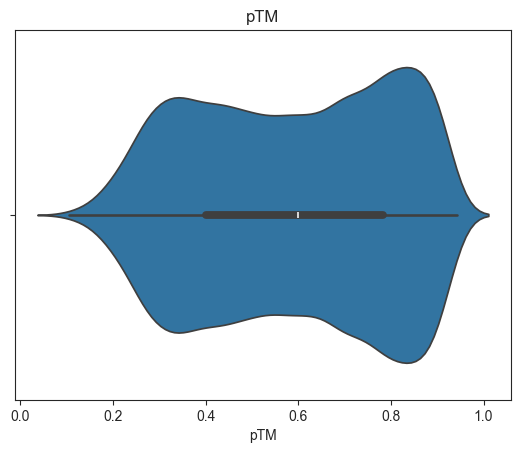

In [25]:
# plotting the pTM - very simple plot to get a grasp
ptmF = sns.violinplot(x=data_ptm["pTM"])
ptmF.set(title = "pTM", xlabel = "pTM")

##### Assessing potential confounders of the quality of the structure prediction - MSA depth

AlphaFold builds protein structure models based on information extracted from MSAs. Hence, the depth of the MSA is one of the metrics to take into account when looking at the overall quality of the protein prediction. To get this information, we will have to loop over the batches, then go into the info file for each protein result, and extract this info from the line 'Sequence coverage'.

In [26]:
 def extract_msa_depth(logfile):
    with open(logfile) as infile:
    # read file, extract lines on MSA depth
        lines = infile.read().splitlines()
        for i, line in enumerate(lines):
           if "Sequence coverage" in line:
             start_i = i
        msa_depth_text = "".join(lines[start_i:i])
    # read text string, extract the position-based MSA depth
        # list to store numbers
    msa_depth_per_pos = []
        # modify string to have space around square brackets for easier digit extraction
    msa_depth_text = msa_depth_text.replace("[", "[ ")
    msa_depth_text = msa_depth_text.replace("]", " ]")
    for word in msa_depth_text.split():
        if word.isdigit():
            msa_depth_per_pos.append(int(word))
    max_depth = max(msa_depth_per_pos)
    avg_depth = np.mean(msa_depth_per_pos)
    return max_depth, avg_depth

In [27]:
# results storage dict
protein_msadepth = {}
# looping over batches
for i in range(0, 21):
    batch = f"batch_{i}"
    path_batch_results = os.path.join(storage_results, batch, batch, "results")
    # go over results
    for ncbi_protein in os.listdir(path_batch_results):
        ncbi_protein_int = int(ncbi_protein)
        # exclude proteins for which we have no AlphaFold predictions
        if ncbi_protein_int not in bug_ids:
            protein_dir = os.path.join(path_batch_results, ncbi_protein)
            logfile = os.path.join(protein_dir, f"{ncbi_protein}_info.log")
            protein_msadepth[ncbi_protein_int] = extract_msa_depth(logfile)
    print(f"Finished {batch} MSA depth analysis.")

Finished batch_0 MSA depth analysis.
Finished batch_1 MSA depth analysis.
Finished batch_2 MSA depth analysis.
Finished batch_3 MSA depth analysis.
Finished batch_4 MSA depth analysis.
Finished batch_5 MSA depth analysis.
Finished batch_6 MSA depth analysis.
Finished batch_7 MSA depth analysis.
Finished batch_8 MSA depth analysis.
Finished batch_9 MSA depth analysis.
Finished batch_10 MSA depth analysis.
Finished batch_11 MSA depth analysis.
Finished batch_12 MSA depth analysis.
Finished batch_13 MSA depth analysis.
Finished batch_14 MSA depth analysis.
Finished batch_15 MSA depth analysis.
Finished batch_16 MSA depth analysis.
Finished batch_17 MSA depth analysis.
Finished batch_18 MSA depth analysis.
Finished batch_19 MSA depth analysis.
Finished batch_20 MSA depth analysis.


In [28]:
# the data for the MSA depth analysis
max_MSA_depth = [x[0] for x in protein_msadepth.values()]
avg_MSA_depth = [x[1] for x in protein_msadepth.values()]
data_MSAd = pd.DataFrame(data = {"protein" : protein_msadepth.keys(), "max MSA depth" : max_MSA_depth, "avg MSA depth" : avg_MSA_depth})

In [29]:
avg_max = round(np.mean(max_MSA_depth))
med_max = np.median(max_MSA_depth)
min30_num = len(data_MSAd[data_MSAd["max MSA depth"] >= 30])
num_proteins = len(max_MSA_depth)
pct_ok = round(min30_num/num_proteins*100, 2)
print(f"On average, the maximal MSA depth used for structure prediction for our {num_proteins} proteins is {avg_max} sequences (median: {med_max}).")
print(f"The maximal MSA depth used for structure prediction for {min30_num} out of our {num_proteins} proteins ({pct_ok}%) is above 30 sequences, which is used as a general rule of thumb.")

On average, the maximal MSA depth used for structure prediction for our 10481 proteins is 798 sequences (median: 99.0).
The maximal MSA depth used for structure prediction for 6512 out of our 10481 proteins (62.13%) is above 30 sequences, which is used as a general rule of thumb.


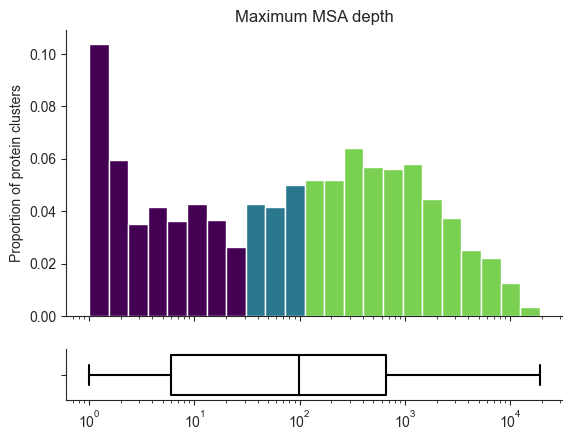

In [31]:
# plotting the MSA depth
sns.set_style("ticks", {"axes.grid" : False})
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
maxF = sns.histplot(x=data_MSAd["max MSA depth"], stat = "proportion", ax=ax_hist, log_scale=True)
sns.despine()
maxF.set(title = "Maximum MSA depth", xlabel = "MSA depth", ylabel =  "Proportion of protein clusters")
for i in range(0,8):
    maxF.patches[i].set_facecolor("#440154") 
for i in range(8,11):
    maxF.patches[i].set_facecolor("#2a788e")
for i in range(11,23):
    maxF.patches[i].set_facecolor("#7ad151")
sns.boxplot(data_MSAd["max MSA depth"], ax=ax_box, orient = "h", fill = False, color = "black")
ax_box.set(xlabel="")
f.savefig(os.path.join(master_dir, "article_figures", "fig3", "MSAdepth_distibution.svg"), format = "svg", transparent = True)

In [32]:
# however, maxima can hide quite large discrepencies over entire proteins, so let's look at the average MSA depth as well
avg_avg = round(np.mean(avg_MSA_depth))
med_avg = round(np.median(avg_MSA_depth))
min30avg_num = len(data_MSAd[data_MSAd["avg MSA depth"] >= 30])
pct_ok_avg = round(min30avg_num/num_proteins*100, 2)
print(f"On average, the average MSA depth used for structure prediction for our {num_proteins} proteins is {avg_avg} sequences (median: {med_avg}).")
print(f"The average MSA depth used for structure prediction for {min30avg_num} out of our {num_proteins} proteins ({pct_ok_avg}%) is above 30 sequences, which is used as a general rule of thumb.")

On average, the average MSA depth used for structure prediction for our 10481 proteins is 474 sequences (median: 62).
The average MSA depth used for structure prediction for 6063 out of our 10481 proteins (57.85%) is above 30 sequences, which is used as a general rule of thumb.


[Text(0.5, 1.0, 'Average MSA depth'), Text(0.5, 0, 'MSA depth (log scaled)')]

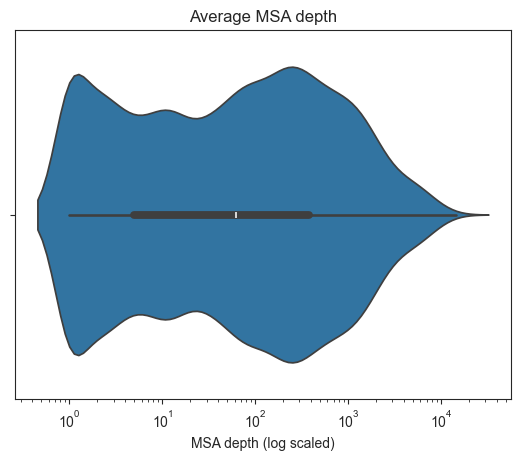

In [33]:
# very simple plot to just get an intuition
avgF = sns.violinplot(x=data_MSAd["avg MSA depth"], log_scale=True)
avgF.set(title = "Average MSA depth", xlabel = "MSA depth (log scaled)")

In [34]:
# let's check whether there is a significant correlation between the MSA depth and the pLDDT
msa_plddt_df = pd.merge(data_MSAd, data_plddt)
msa_plddt_df["max MSA depth log"] = np.log10(msa_plddt_df["max MSA depth"])
print(pearsonr(msa_plddt_df["max MSA depth log"], msa_plddt_df["avg pLDDT"]))

PearsonRResult(statistic=np.float64(0.7089444064212573), pvalue=np.float64(0.0))


In [35]:
pearsonr(msa_plddt_df["max MSA depth log"], msa_plddt_df["avg pLDDT"])[0]**2

np.float64(0.502602171395989)

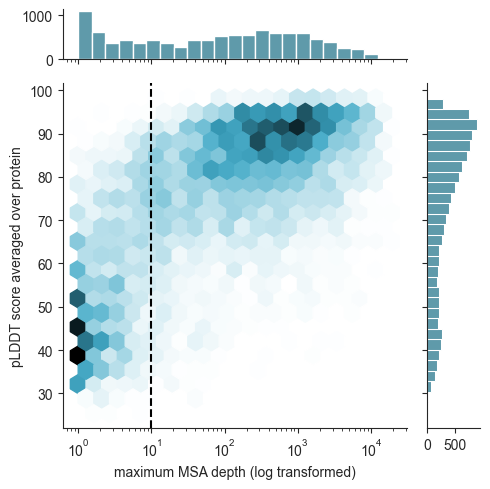

In [36]:
# let's plot this information through a biplot
plot = sns.jointplot(msa_plddt_df, x = "max MSA depth", y = "avg pLDDT", kind = "hex", height = 5, color = "#2a788e", 
                     marginal_ticks = True, xscale = "log", gridsize = 20)
plot.ax_joint.axvline(x=10, color = "black", linestyle = "dashed")
plot.set_axis_labels("maximum MSA depth (log transformed)", "pLDDT score averaged over protein", fontsize=10)
plot.figure.tight_layout() 
plot.ax_joint.set_xscale('log')
plot.savefig(os.path.join(master_dir, "article_figures", "fig3", "jointplot_logMSAdepth_pLDDT.svg"), format = "svg", transparent = True)

There appears to be a significant shift in pLDDT once MSA depth surpasses 10 sequences, let's check this is difference.

In [37]:
mannwhitneyu(msa_plddt_df[msa_plddt_df["max MSA depth"] > 10]["avg pLDDT"], msa_plddt_df[msa_plddt_df["max MSA depth"] <= 10]["avg pLDDT"], alternative = "greater")

MannwhitneyuResult(statistic=np.float64(20764332.0), pvalue=np.float64(0.0))

In [38]:
mean_o30 = np.mean(msa_plddt_df[msa_plddt_df["max MSA depth"] > 10]["avg pLDDT"])
std_o30 = np.std(msa_plddt_df[msa_plddt_df["max MSA depth"] > 10]["avg pLDDT"])
print("Over 30:", mean_o30, " +- ", std_o30)
mean_u30 = np.mean(msa_plddt_df[msa_plddt_df["max MSA depth"] <= 10]["avg pLDDT"])
std_u30 = np.std(msa_plddt_df[msa_plddt_df["max MSA depth"] <= 10]["avg pLDDT"])
print("Under 30:", mean_u30, " +- ", std_u30)

Over 30: 82.21018408229561  +-  11.81262837894074
Under 30: 54.651480763013254  +-  15.520993184301304


Moreover, the relationship between MSA depth and pLDDT seems far from linear, let's calculate Spearman's corration instead of Pearson's.

In [39]:
spearmanr(msa_plddt_df["max MSA depth"], msa_plddt_df["avg pLDDT"])[0]**2

np.float64(0.46149313434858785)

##### Assessing potential confounders of the quality of the structure prediction - protein length

Let's also look at another potentially confounding property: protein length.

In [40]:
# let's check whether there is a significant correlation between the protein size and the pLDDT
len_plddt_df = pd.merge(proteins_structure_prediction, data_plddt, left_on = "ncbi_protein_id", right_on = "protein")
print(pearsonr(len_plddt_df["ncbi_protein_length"], len_plddt_df["avg pLDDT"]))

PearsonRResult(statistic=np.float64(0.086488939222896), pvalue=np.float64(7.312945249977428e-19))


In [41]:
print(spearmanr(len_plddt_df["ncbi_protein_length"], len_plddt_df["avg pLDDT"]))

SignificanceResult(statistic=np.float64(0.07684349716627971), pvalue=np.float64(3.3346460326812915e-15))


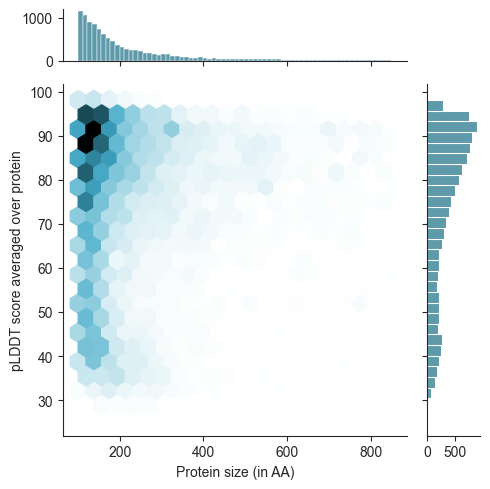

In [42]:
# let's plot this information through a biplot
plot = sns.jointplot(len_plddt_df, x = "ncbi_protein_length", y = "avg pLDDT", kind = "hex", height = 5, color = "#2a788e", 
                     marginal_ticks = True, gridsize = 20)
plot.set_axis_labels("Protein size (in AA)", "pLDDT score averaged over protein", fontsize=10)
plot.figure.tight_layout() 
plot.savefig(os.path.join(master_dir, "article_figures", "fig3", "jointplot_proteinsize_pLDDT.svg"), format = "svg", transparent = True)

There is a very strong overrepresentation of proteins with size below 200 AA, let's see if we can rebalance the dataset to better assess this relation.

In [44]:
len_plddt_df["len_class"] = (len_plddt_df["ncbi_protein_length"] < 200)

In [45]:
len_plddt_df.groupby("len_class").count()

,ncbi_protein_id,ncbi_protein_name,ncbi_protein_length,sequence,protein,avg pLDDT
len_class,,,,,,
False,3830,3830,3830,3830,3830,3830
True,6651,6651,6651,6651,6651,6651


In [46]:
# attempt at undersampling to improve overrepresentation < 200 AA proteins
rus = RandomUnderSampler(sampling_strategy = "majority", random_state = 0)
X = len_plddt_df.drop("len_class", axis = 1)
y = len_plddt_df["len_class"]
X_resampled, y_resampled = rus.fit_resample(X, y)

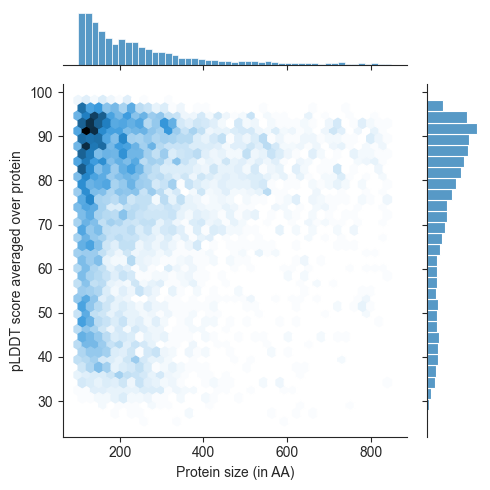

In [48]:
# let's plot this information through a biplot
plot = sns.jointplot(X_resampled, x = "ncbi_protein_length", y = "avg pLDDT", kind = "hex", height = 5)
plot.set_axis_labels("Protein size (in AA)", "pLDDT score averaged over protein", fontsize=10)
plot.figure.tight_layout() 

In [50]:
print(pearsonr(X_resampled["ncbi_protein_length"], X_resampled["avg pLDDT"])[0]**2)

0.0077204369046189126


In [47]:
# attempt at oversampling to improve overrepresentation < 200 AA proteins
ros = RandomOverSampler(sampling_strategy = "minority", random_state = 0)
X_resampled2, y_resampled2 = ros.fit_resample(X, y)

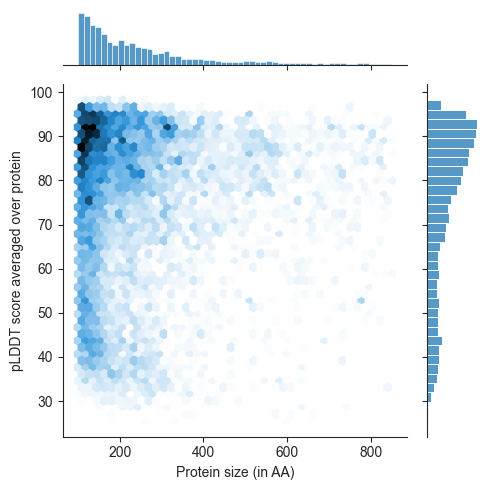

In [49]:
# let's plot this information through a biplot
plot = sns.jointplot(X_resampled2, x = "ncbi_protein_length", y = "avg pLDDT", kind = "hex", height = 5)
plot.set_axis_labels("Protein size (in AA)", "pLDDT score averaged over protein", fontsize=10)
plot.figure.tight_layout() 

In [51]:
# final attempt, extensive binning - still remains negligible
ranges = [(100,150), (150,200), (200,250), (250,300), (300,350), (350,400), (400,450), (450,500), (500,550), (550,600), (600,650), (650,700), (700,750), (750, 800), (800,850)]
r2_list = list()
for srange in ranges:
    data = len_plddt_df[(len_plddt_df["ncbi_protein_length"] > srange[0]) & (len_plddt_df["ncbi_protein_length"] <= srange[1])]
    r2 = pearsonr(data["ncbi_protein_length"], data["avg pLDDT"])[0]**2
    r2_list.append(r2)
    print(srange, r2)
print(np.mean(r2_list))

(100, 150) 0.00047955426006675127
(150, 200) 8.752751670669293e-05
(200, 250) 4.466055068839266e-05
(250, 300) 1.1071230942706972e-05
(300, 350) 0.0006324794646783591
(350, 400) 0.0009211911205143973
(400, 450) 0.01013532135920194
(450, 500) 0.022844737019268008
(500, 550) 0.001773740774087824
(550, 600) 0.057895987013157166
(600, 650) 0.0022683402014098595
(650, 700) 0.0007873627085819771
(700, 750) 0.05578777898578429
(750, 800) 0.023246144598209614
(800, 850) 0.10775047309479592
0.01897775799320626


In [52]:
metrics_df = pd.merge(len_plddt_df, msa_plddt_df, on = "protein")
metrics_df = metrics_df.drop(["ncbi_protein_id", "avg pLDDT_x"], axis=1)
metrics_df.rename({"avg pLDDT_y" : "avg pLDDT"}, inplace = True)
metrics_df.to_csv(os.path.join(pipeline_search_dir, "b_structure", "structure_prediction", "prediction_metrics.tsv"), sep = "\t", index = False) 

#### Goal 4: Compare protein structures to the PDB and AlphaFold database.

Now that we have these protein structures, we can assess whether they are structurally similar to other proteins. We will do this by using FoldSeek (easy-search with default parameters: sensitivity = 9.5, E-value = 0.001) to compare our proteins against the PDB and AlphaFold database. This will be achieved in batches of 300 proteins at a time. In order to do so, we again have to prepare jobs for the HPC. 

This entails copying and organizing the relevant structure files, and making the job scripts and job arrays.

In [ ]:
os.mkdir(os.path.join(pipeline_search_dir, "b_structure", "structure_comparison"))

In [53]:
# list of successfull structure prediction proteins
cluster_reps_struc = list(set(all_cluster_reps) - set(bug_ids))

In [54]:
# creating dictionary to store whether relaxation worked
relax_best_dict = {}
for key in cluster_reps_struc:
    if key not in relaxation_failed_ids:
        relax_best_dict[key] = "relax"
    else:
        relax_best_dict[key] = "best"

In [ ]:
# copying the structure files
for index_batch, batch in enumerate(list(batched(all_cluster_reps,500))):
    batch_path = os.path.join(storage_results, f"batch_{index_batch}", f"batch_{index_batch}")
    # check if ID in dictionary
    for protein in batch:
        if protein in relax_best_dict.keys():
    # for proteins with relaxed structure, we copy the relaxed structure
            if relax_best_dict.get(protein) == "relax":
                relaxed_path = os.path.join(batch_path, "results", f"{protein}", f"{protein}_relaxed.pdb")
                shutil.copyfile(relaxed_path, 
                                os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"{protein}_relaxed.pdb"))
    # for proteins with no relaxed structure, we copy the best model
            if relax_best_dict.get(protein) == "best":
                for item in os.listdir(os.path.join(batch_path, "results", f"{protein}")):
                    if "rank_1" in item and ".pdb" in item:
                        best_path = os.path.join(batch_path, "results", f"{protein}", item)
                        shutil.copyfile(best_path,
                                        os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"{protein}_best.pdb"))

In [ ]:
# organizing them in batches of 300 proteins
for index_batch, batch in enumerate(list(batched(relax_best_dict.keys(),300))):
    # make directory
    os.makedirs(os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"batch_{index_batch}"))
    # move input structures into batches
    for protein in batch:
        if relax_best_dict.get(protein) == "relax":
            structure_path_in = os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"{protein}_relaxed.pdb")
            structure_path_out = os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"batch_{index_batch}", f"{protein}_relaxed.pdb")
        if relax_best_dict.get(protein) == "best":
            structure_path_in = os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"{protein}_best.pdb")
            structure_path_out = os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"batch_{index_batch}", f"{protein}_best.pdb")
        shutil.move(structure_path_in, structure_path_out)

In [ ]:
# creating job scripts and job array data files
for index_batch, batch in enumerate(list(batched(relax_best_dict.keys(),300))):
    batch_dir = os.path.join(pipeline_search_dir, "b_structure", "structure_comparison", f"batch_{index_batch}")
    # create data file per batch
        # copy template
    shutil.copyfile(os.path.join(master_dir, "templates", "data_foldseek_5.csv"),
                    os.path.join(batch_dir, "data_foldseek_5.csv"))
        # modify template
    files = os.listdir(batch_dir)
    files.remove("data_foldseek_5.csv")
    with open(os.path.join(batch_dir, "data_foldseek_5.csv"), "a+") as data_file:
        for batch in list(batched(files,5)):
            string = ""
            for protein_pdb in batch:
                if "relaxed.pdb" in protein_pdb:
                    id = protein_pdb.removesuffix("_relaxed.pdb")
                elif "best.pdb" in protein_pdb:
                    id = protein_pdb.removesuffix("_best.pdb")
                aln_pdb = f"{id}_aln_pdb.txt"
                aln_af50m = f"{id}_aln_af50m.txt"
                string += f"{protein_pdb},{aln_pdb},{aln_af50m},"
            string = string.removesuffix(",")
            string += "\n"
            data_file.write(string)
    #  copy job script into batch
    shutil.copyfile(os.path.join(master_dir, "templates", "script_foldseek_5.slurm"),
                    os.path.join(batch_dir, "script_foldseek_5.slurm"))    

We can now move this to the HPC and submit the jobs. 

In [55]:
# link to stored results, not stored in place due to memory issues
storage_results_comp = os.path.join(os.path.join(os.environ["USERPROFILE"]), "Desktop", "phage_annotation_input", "structure_comparison") 
# used different batching, so let's get batching from there
dict_batch_comp_prot = {}
dict_batch_comp = {}
for protein in cluster_reps_struc:
    for index_batch in range(0,35):
        batch_dir = os.path.join(storage_results_comp, f"batch_{index_batch}", f"batch_{index_batch}")
        if os.path.isfile(os.path.join(batch_dir, f"{protein}_aln_af50m.txt")) and os.path.isfile(os.path.join(batch_dir, f"{protein}_aln_pdb.txt")):
            dict_batch_comp_prot[protein] = index_batch
for key, value in dict_batch_comp_prot.items():
    if value in dict_batch_comp:
        dict_batch_comp[value].append(key)
    else:
        dict_batch_comp[value] = [key]
dict_batch_comp = dict(sorted(dict_batch_comp.items()))

During inspection of the FoldSeek output files, I noticed many had FoldSeek hits with reported Evalues > 0.001, which should be the default Evalue treshold. Upon inspection of the output log files, the Evalue treshold was indeed not the default setting (although no option was specified by me), but 10. The sensitivity was however identical to the default setting. As such, my 'raw' hits actually contain many hits that I would want to filter out, as I aimed for default Evalue treshold settings. Hence, I will fix this filtering here.

In [56]:
 # reading in the FoldSeek output files for a specific protein in a batch 
def read_foldseek_protein(batch, protein):
    path_batch = os.path.join(storage_results_comp, f"batch_{batch}", f"batch_{batch}")
    pdb_raw = os.path.join(path_batch, f"{protein}_aln_pdb.txt")
    af50m_raw = os.path.join(path_batch, f"{protein}_aln_af50m.txt")
    df_pdb_raw = pd.read_table(pdb_raw, header = None, names = ["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend","evalue","bits","prob","lddt","lddtfull"])
    df_af50m_raw = pd.read_table(af50m_raw, header = None, names = ["query","target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend","evalue","bits","prob","lddt","lddtfull"])
    return df_pdb_raw, df_af50m_raw

In [57]:
def filter_foldseek(foldseek_df):
    data_filtered = foldseek_df[foldseek_df["evalue"] <= 0.001]
    return data_filtered

In [ ]:
# loop over batches
for batch_index, protein_list in dict_batch_comp.items():
    for protein in protein_list:
        # filter out dataframes
        pdb_r_filtered = filter_foldseek(read_foldseek_protein(batch_index, protein)[0])
        af50m_r_filtered = filter_foldseek(read_foldseek_protein(batch_index, protein)[1])
        # store new dataframes
        pdb_r_filtered.to_csv(os.path.join(storage_results_comp, f"batch_{batch_index}", f"batch_{batch_index}", f"{protein}_foldseek_pdb_default.csv"), index=False) 
        af50m_r_filtered.to_csv(os.path.join(storage_results_comp, f"batch_{batch_index}", f"batch_{batch_index}", f"{protein}_foldseek_af50m_default.csv"), index=False) 
    print(f"Finished batch {batch_index} FoldSeek hit filtering.")